## Preparation

This section is where we prepare for the project, through a variety of initial steps. The steps in this section are as follows:

- Importing Packages
- Importing Data
- Dropping NA Values
- Subsetting Data

### Importing Packages

In [1]:
#Data management
import pandas as pd
import numpy as np
np.random.seed(0)
#from pandas_profiling import ProfileReport

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

#Test
from collections import Counter

### Importing Data

In [2]:
#Training Data
path = "../data/raw/twitter_training.csv"
train_df = pd.read_csv(path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

#Test Data (Not to be used until the full model has been trained)
test_path = "../data/raw/twitter_validation.csv"
test_df = pd.read_csv(test_path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

### Dropping NA Values

Here, we drop any rows with null values, as these miss out on key information.

In [3]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [4]:
train_df.shape

(73996, 4)

### Subsetting Data

As this dataset is quite large, during the exploration process we begin by subsetting the data during the training process, to speed up any testing steps. We also reset the index of the dataframe, to make adding columns easier later on in the process.

In [5]:
df = train_df.sample(frac=0.1)
df.reset_index(drop=True, inplace=True)

## Data Exploration

Here, we explore the data, testing if it is balanced, and checking for patterns in missing rows. This can generally be done in an automated fashion with pandas-profiling. The sections under this header include:

- Basic visualisation
- Automated Data Exploration with pandas-profiling
- Checking for balance in output categories

### Basic Visualisation

We can display basic statistics about the data using pandas, and also view a few entries of the dataset, to see example points with which we'll work.

In [6]:
#See overall information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       7400 non-null   int64 
 1   Entity         7400 non-null   object
 2   Sentiment      7400 non-null   object
 3   Tweet_Content  7400 non-null   object
dtypes: int64(1), object(3)
memory usage: 231.4+ KB


In [7]:
#Display a few entries
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2535,Borderlands,Negative,@ Borderlands. Can we get a big fix please? I'...
1,11073,TomClancysGhostRecon,Negative,@GhostRecon You call 1.1.0 an update. You're h...
2,3024,Dota2,Neutral,I'm excited to watch the EU's closed qualifyin...
3,6719,Fortnite,Negative,"anyways but my fortnite here,, im annoyed."
4,1533,Battlefield,Negative,Collateral with the revolver is so satisfying....


### Automated Data Exploration with Pandas-Profiling

Pandas-profiling is a library used to automatically explore data. This gives us a good overview of the dataset, which we can use to inform our later work.

In [8]:
#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#profile

### Checking Balance of the Data in Output Categories

We want to check the balance of the output column (Sentiment), such that we don't train a model that always predicts one output. This model might have a high accuracy, but we wouldn't have learned anything about trends in the data, other than the count in the most common sentiment. It might be tempting to think about balancing the test data too, but remember that data in the real world will be unlikely to come nicely balanced, and test data is analagous to real world data


The proportion of sentiments ranges from about 0.15 to 0.3, which is generally good balance, such that we are unlikely to see a scenario in which only one class is predicted. We will however be looking out for if our training accuracy forms a plateau at about 0.3, which could be indicative of this problem.

<BarContainer object of 4 artists>

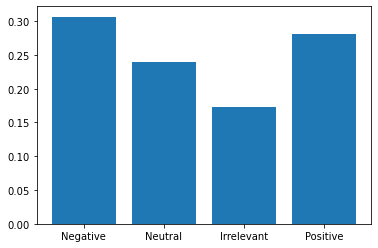

In [9]:
#Checking balance of target classes
sentiments = list(df["Sentiment"].unique())

sentiment_nums = [len(df[df["Sentiment"] == sentiment]) / len(df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

## Basic Data Enrichment

Here, we consider basic features that can enhance the dataset. This will include one-hot encoding of the categorical "Entity" variable. We can also use pre-trained NLP systems here to extract features from the text, such as the one from TextBlob, giving us a "polarity" and "subjectivity" value from any text that we give it. These extra features are added to the dataframe.

We can also create an indexer to convert sentiments from labels to indexes, and back again. This is useful in understanding our predictions later on.

Sections under this header include:

- One-Hot Encoding
- Enrichment with Pre-Trained NLP Models (TextBlob)
- Labels to Indexes (and Back Again)

### One-Hot Encoding

Here, we create a Boolean column for each possible entity, as there are only 32 of these. 32 columns are added, each signifying if the Tweet was related to the given entity. Each Tweet will only be related to one entity in total.

In [10]:
#View all possible entities
print(df["Entity"].unique())
print(len(df["Entity"].unique()))

['Borderlands' 'TomClancysGhostRecon' 'Dota2' 'Fortnite' 'Battlefield'
 'Hearthstone' 'Amazon' 'Google' 'Overwatch' 'Nvidia' 'FIFA'
 'AssassinsCreed' 'Verizon' 'CallOfDuty' 'Cyberpunk2077' 'Xbox(Xseries)'
 'CS-GO' 'WorldOfCraft' 'Microsoft' 'CallOfDutyBlackopsColdWar'
 'MaddenNFL' 'HomeDepot' 'ApexLegends' 'TomClancysRainbowSix'
 'PlayerUnknownsBattlegrounds(PUBG)' 'LeagueOfLegends' 'Facebook'
 'GrandTheftAuto(GTA)' 'NBA2K' 'RedDeadRedemption(RDR)' 'johnson&johnson'
 'PlayStation5(PS5)']
32


In [11]:
#One-hot encode using Pandas' get_dummies()
onehot = pd.get_dummies(df["Entity"], prefix="Entity")

#Join these new columns back into the DataFrame
df = df.join(onehot)

#Display a sample of the data with our new columns
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,...,Entity_Overwatch,Entity_PlayStation5(PS5),Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson
0,2535,Borderlands,Negative,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,11073,TomClancysGhostRecon,Negative,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3024,Dota2,Neutral,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6719,Fortnite,Negative,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1533,Battlefield,Negative,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Remove the Entity column, as we have transformed this data into a more usable format

df = df.drop("Entity", axis=1)

### Enrichment with Pre-Trained Models (TextBlob)

Here, we use the built-in functionality of TextBlob to add dimensionality to the data, by using it to analyse the text of the "Tweet_Content" column, and storing the outputs in a new column. This pre-trained model allows us to easily analyse strings of text, without any of the more involved NLP methods. Though we also plan to use more methods for NLP, this step can be a good to see if this model picks up on areas that our created one does not.

In [13]:
#Adding dimensions with textblob
def tb_enrich(ls):
    #Enriches a column of text with TextBlob Sentiment Analysis outputs
    tb_polarity = []
    tb_subject = []

    for tweet in ls:
        tb_polarity.append(TextBlob(tweet).sentiment[0])
        tb_subject.append(TextBlob(tweet).sentiment[1])
    

    return tb_polarity, tb_subject
    
df["Polarity"], df["Subjectivity"] = tb_enrich(list(df["Tweet_Content"]))

In [14]:
df.head()

,Tweet_ID,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Polarity,Subjectivity
0,2535,Negative,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.3625
1,11073,Negative,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.5375,0.4750
2,3024,Neutral,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.1375,0.4250
3,6719,Negative,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.4000,0.8000
4,1533,Negative,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.0000


### Labels to Indexes (and Back Again)

Here, as discussed above, we create a dictionary in order to change the text in the "Sentiment" column into an index representing the predicted sentiment.

We then convert the "Sentiment" column in the training data to the labels, which is what we will learn to predict

In [15]:
#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [16]:
#Test each function
print(names_to_ids(["Positive", "Negative", "Irrelevant", "Neutral"]))
print(ids_to_names([0,1,2,3]))

[3 2 1 0]
['Neutral' 'Irrelevant' 'Negative' 'Positive']


In [17]:
#Convert the "Sentiment" column into indexes
df["Sentiment"] = names_to_ids(df["Sentiment"])

In [18]:
df.head()

,Tweet_ID,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Polarity,Subjectivity
0,2535,2,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.3625
1,11073,2,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.5375,0.4750
2,3024,0,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.1375,0.4250
3,6719,2,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.4000,0.8000
4,1533,2,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.0000


## NLP Data Enrichment

In this section, we work with the text in the "Tweet_Content" column, extracting all the insight from this that we can, and converting it into a useable format for the neural network that we will train later. This involves removing words that have little meaning (stop word removal), and grouping words with the same meaning regardless of details such as tense (lemmatisation). Then, we use tokenisation in order to codify the presence of words into a matrix, similar in fashion to one-hot encoding. This is known as a "Bag of Words" method.

Sections under this header include:

- Stop Word Removal and Lemmatisation with NLTK
- Tokenisation
- Adding the Tokenised Strings to the DataFrame

### Stop Word Removal and Lemmatisation with NLTK

Here, we first split each string into its individual words, before checking if these:
1. Contain text
2. Are in the list of stopwords

If there is no text in the word, meaning there are only numbers or punctuation (or other characters), or the word is a stop word (words such as "with", "a", "the"), then the word is removed from the string.

We also lemmatise in this step, in which we convert words into their root form, such that tense and other details can be ignored in our final model (a negative statement in the past tense is still negative).

In [19]:
def remove_stopwords(ls):
    #Lemmatises, then removes stop words
    ls = [lemmatiser.lemmatize(word) for word in ls if word not in (stop_english) and (word.isalpha())]
    
    #Joins the words back into a single string
    ls = " ".join(ls)
    return ls

#Splits each string into a list of words
df["Tweet_Content_Split"] = df["Tweet_Content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["Tweet_Content_Split"] = df["Tweet_Content_Split"].apply(remove_stopwords)

In [20]:
df.head()

,Tweet_ID,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Polarity,Subjectivity,Tweet_Content_Split
0,2535,2,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0000,0.3625,Borderlands Can get big fix please I reset ent...
1,11073,2,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.5375,0.4750,GhostRecon You call update You laugh stay conn...
2,3024,0,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.1375,0.4250,I excited watch EU closed qualifying match EU ...
3,6719,2,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.4000,0.8000,anyways fortnite annoyed
4,1533,2,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,Collateral revolver unk


### Tokenisation

We create tokens for the most common words in the dataset, so we can represent the presence of words in our created corpus (the n most common words) with a list of integers. 

In [21]:
#Define the Tokeniser
tokeniser = Tokenizer(num_words=1000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(df["Tweet_Content_Split"])

In [22]:
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_matrix(list(df["Tweet_Content_Split"]))

In [23]:
tweet_tokens.shape

(7400, 1000)

### Adding the Tokenised Strings to the DataFrame

Currently, the tokens are contained in a matrix titled "tweet_tokens". We then want to combine these back into the dataframe containing all of the current data. This is completed below, and then we test to make sure that this has occurred correctly by looking at the number of columns compared to that of the original matrices.

In [24]:
print(df.shape)
print(tweet_tokens.shape)

(7400, 38)
(7400, 1000)


In [25]:
#Combining the dataframe with the tokens using pd.concat
full_df = pd.concat([df, pd.DataFrame(tweet_tokens)], sort=False, axis=1)
full_df.shape

(7400, 1038)

## Final Data Preparation

The data is now almost ready for a model to be trained on it, but a few final preparations will need to occur. For example, we need to drop the columns that we don't plan to use, such as the "Tweet_Content" column, which has had its useful information extracted already.

We also split the data into a training and test set, such that we can evaluate our model's performance without touching the held-out data. We do this because if we continually test against this held-out data, it loses its usefulness as unseen "real-world" data.

Sections under this header include:
- Dropping Unused Data
- Test-Train Split

### Dropping Unused Data

We drop non-useful columns from the DataFrame here. These either have no use (Tweet ID), or have already had the useful information extracted (Tweet Content). We also remove the "y" or dependent variable here, so we don't accidentally train on it.

In [26]:
#Remove dependent variable
y = full_df["Sentiment"]

#Drop all non-useful columns
full_df = full_df.drop(["Sentiment", "Tweet_ID", "Tweet_Content", "Tweet_Content_Split"], axis=1)

In [27]:
#Display final shape
full_df.shape

(7400, 1034)

### Test-Train Split

Here, we use SciKit-Learn's inbuilt function to split our data into a test set and a train set, with the appropriate labels. We use a constant random state to make this replicable.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(full_df, y, test_size=0.2, random_state=1)

## Model Construction and Training

Finally, it is time to construct our model. In this case, we use a neural network constructed with Keras. We then train it with our data in the training dataset, and validate using the test datasets.

Sections under this header include:
- Model Construction
- Training

### Model Construction

Here, we define the neural network that we will train to predict the output. This model is constructed with the following layers:
1. Dense
2. Dropout

The Dense layers are fully-connected layers. This means that inbetween each layer, we can transfer data from any neuron to any one in the next layer (or indeed all others), scaled by the weight associated with that transfer. These weights are trained.

The Dropout layers prevent our overall weights from getting too large, as can happen with larger neural networks. This helps to stop certain areas of the network from overloading the network as a whole.


In [29]:
#Test model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=1034, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

### Training

Next, we fit this model with our data, using backpropagation, for 30 epochs. We can view the increase in accuracy of the model through the different epochs, on both the training and test dataset.

In [30]:
h = model.fit(
     X_train, y_train,
     validation_data=(X_test, y_test),
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/30
185/185 [==============================] - 1s 3ms/step - loss: 1.2969 - accuracy: 0.3829 - val_loss: 1.2252 - val_accuracy: 0.4426
Epoch 2/30
185/185 [==============================] - 0s 2ms/step - loss: 1.1477 - accuracy: 0.4833 - val_loss: 1.2102 - val_accuracy: 0.4547
Epoch 3/30
185/185 [==============================] - 0s 2ms/step - loss: 1.0464 - accuracy: 0.5486 - val_loss: 1.1872 - val_accuracy: 0.4973
Epoch 4/30
185/185 [==============================] - 1s 3ms/step - loss: 0.9398 - accuracy: 0.6025 - val_loss: 1.2262 - val_accuracy: 0.4953
Epoch 5/30
185/185 [==============================] - 0s 2ms/step - loss: 0.8484 - accuracy: 0.6463 - val_loss: 1.2368 - val_accuracy: 0.5014
Epoch 6/30
185/185 [==============================] - 0s 2ms/step - loss: 0.7745 - accuracy: 0.6765 - val_loss: 1.3381 - val_accuracy: 0.5095
Epoch 7/30
185/185 [==============================] - 0s 2ms/step - loss: 0.7077 - accuracy: 0.6993 - val_loss: 1.3791 - val_accuracy: 0.5122
Epoch 

## Model Evaluation

Now that we've trained the model, we can view it's accuracy with a confusion matrix. This allows us to see the predictions for Tweets with various true values. From this, we might see that we are better at predicting certain classes than others, such as in this model, where we can predict Negative and Positive sentiment significantly better than Irrelevant or Neutral.

In [31]:
#Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

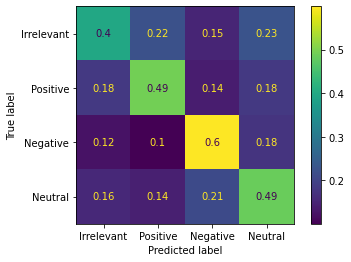

In [32]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

## Training with Full Dataset

Now that we are happy with our model, we can train using the full dataset, and predict the held-out test data. This involves performing all of our transformation steps on both this training dataset and the held-out test data. Luckily, we can reuse the code from above to achieve this, so little further explanation is required.

In [33]:
#Use the full dataset!
df = train_df

# the test dataframe was loaded earlier and is named test_df

### Basic Data Enrichment

In [34]:
#One-hot encode using Pandas' get_dummies()

##Train
onehot = pd.get_dummies(df["Entity"], prefix="Entity")

#Join these new columns back into the DataFrame
df = df.join(onehot)


##Test
onehot = pd.get_dummies(test_df["Entity"], prefix="Entity")

test_df = test_df.join(onehot)

In [35]:
#Enrich using TextBlob's built in sentiment analysis

##Train
df["Polarity"], df["Subjectivity"] = tb_enrich(list(df["Tweet_Content"]))


##Test
test_df["Polarity"], test_df["Subjectivity"] = tb_enrich(list(test_df["Tweet_Content"]))

In [36]:
#Convert the "Sentiment" column into indexes

##Train
df["Sentiment"] = names_to_ids(df["Sentiment"])
y = df["Sentiment"]

##Test
test_df["Sentiment"] = names_to_ids(test_df["Sentiment"])
y_test = test_df["Sentiment"]

### NLP Data Enrichment

In [37]:
#Removing stopwords and lemmatising

##Train
#Splits each string into a list of words
df["Tweet_Content_Split"] = df["Tweet_Content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["Tweet_Content_Split"] = df["Tweet_Content_Split"].apply(remove_stopwords)

##Test
test_df["Tweet_Content_Split"] = test_df["Tweet_Content"].apply(word_tokenize)

test_df["Tweet_Content_Split"] = test_df["Tweet_Content_Split"].apply(remove_stopwords)

In [38]:
#Tokenisation

#Define the Tokeniser
tokeniser = Tokenizer(num_words=1000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(df["Tweet_Content_Split"])

##Train
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_matrix(list(df["Tweet_Content_Split"]))

##Test
#Tokenise our column of edited Tweet content
tweet_tokens_test = tokeniser.texts_to_matrix(list(test_df["Tweet_Content_Split"]))

In [39]:
#Combining the dataframe with the tokens using pd.concat

#Reset axes to avoid overlapping
df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

##Train
full_df = pd.concat([df, pd.DataFrame(tweet_tokens)], sort=False, axis=1)

##Test
full_test_df = pd.concat([test_df, pd.DataFrame(tweet_tokens_test)], sort=False, axis=1)

In [40]:
#Final prep

##Train
#Drop all non-useful columns
full_df = full_df.drop(["Sentiment", "Tweet_ID", "Tweet_Content", "Tweet_Content_Split", "Entity"], axis=1)


##Test
full_test_df = full_test_df.drop(["Sentiment", "Tweet_ID", "Tweet_Content", "Tweet_Content_Split", "Entity"], axis=1)

### Model Definition and Training

This time, we train with all of the available training data

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=1034, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [42]:
h = model.fit(
     full_df, y,
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/30
2313/2313 [==============================] - 5s 2ms/step - loss: 1.0559 - accuracy: 0.5511
Epoch 2/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.8679 - accuracy: 0.6511
Epoch 3/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.7964 - accuracy: 0.6840
Epoch 4/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.7550 - accuracy: 0.7030
Epoch 5/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.7264 - accuracy: 0.7181
Epoch 6/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.7048 - accuracy: 0.7290
Epoch 7/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.6898 - accuracy: 0.7346
Epoch 8/30
2313/2313 [==============================] - 5s 2ms/step - loss: 0.6762 - accuracy: 0.7407
Epoch 9/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.6634 - accuracy: 0.7477
Epoch 10/30
2313/2313 [==============================] - 4s 2ms/step - loss: 0.654

## Final Model Evaluation

In [43]:
#Generate predictions
y_pred = np.argmax(model.predict(full_test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

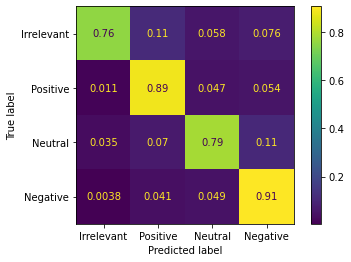

In [44]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [45]:
#To see the final accuracy
accuracy_score(y_test, y_pred)

0.841